Let's clean up `Strokes.ipynb` a bit and see if the choice of classifier makes any difference, using scikit-learn.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import mlab
import numpy as np
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio

In [7]:
alphabet = ''.join(chr(ord("A") + i) for i in range(26))

In [8]:
def load_dataset():
    letters = np.empty((4, 26, 20), dtype=object)
    for i, j, k in np.ndindex(letters.shape):
        subject = i + 1
        letter = alphabet[j]
        fs, x = scipy.io.wavfile.read(f"letters/{subject}/{letter}/PZ/{k}.wav")
        letters[i, j, k] = x
    # Assumes all letters have same sample rate.
    return letters, fs

In [142]:
def filter_transients(x, n):
    return np.min(x[:len(x)//n*n].reshape((-1, n)), axis=1)

def find_strokes(x, fs, verbose=False):
    X, freqs, t = mlab.specgram(x, Fs=fs, NFFT=512, noverlap=256)
    summed = np.sum(X[15:30], axis=0)
    filtered = filter_transients(summed, 3)
    smoothed = np.convolve(filtered, np.ones(6))
    smoothed /= np.max(smoothed)
    peaks, info = scipy.signal.find_peaks(smoothed, height=0.2, prominence=0.15, distance=10)
    amp = info["peak_heights"]
    if verbose:
        # plt.plot(summed[::3] / np.max(summed))
        # plt.plot(filtered / np.max(filtered))
        plt.plot(smoothed)
        plt.scatter(peaks, amp, c='red')
        plt.show()
    times = t[peaks]
    times -= times[0]
    # Interestingly, normalizing times seems to make the results slightly worse.
    # (But this may be simply becuase stroke identification is not very good yet.)
    if len(times) > 1:
        times /= times[-1]
    # Matrix of [[stroke time, stroke amplitude]]
    return np.vstack((times, amp)).T

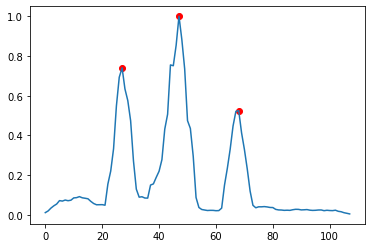

[[0.         0.74029854]
 [0.11609977 1.        ]
 [0.23800454 0.52454731]]


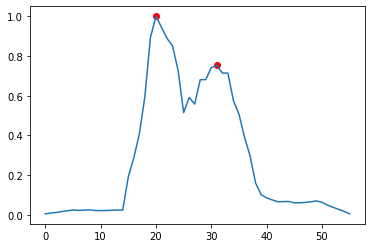

[[0.         1.        ]
 [0.06385488 0.75268031]]


In [22]:
def foo():
    letters, fs = load_dataset()
    print(find_strokes(letters[0, 17, 16], fs, verbose=True))
    print(find_strokes(letters[0, 2, 16], fs, verbose=True))

foo()

In [104]:
def nearest_neighbor(x, train):
    best = None
    for i, y in np.ndenumerate(train):
        # NOTE: If the number of strokes does not match, this dismisses the match completely.
        if len(x) != len(y):
            continue
        dist = np.linalg.norm(x - y)
        if best is None or dist < best[1]:
            best = (i, dist)
    return best[0][1]

In [105]:
def eval_accuracy(test, train):
    results = np.empty(test.shape)
    for i, x in np.ndenumerate(test):
        results[i] = nearest_neighbor(x, train)
    return np.mean(np.indices(results.shape)[1] == results)

In [106]:
def process_dataset(letters, fs):
    strokes = np.empty(letters.shape, dtype=object)
    for i in np.ndindex(letters.shape):
        strokes[i] = find_strokes(letters[i], fs)
    return strokes

In [139]:
def run():
    letters, fs = load_dataset()
    strokes = process_dataset(letters, fs)
    test = strokes[:, :, 15:]
    train = strokes[:, :, :15]
    print(f"With all subjects in training data: {round(eval_accuracy(test, train) * 100, 2)}%")
    for subject in range(len(strokes)):
        test = strokes[subject][None]
        train = np.vstack((strokes[:subject], strokes[subject+1:]))
        print(f"Subject {subject}: {round(eval_accuracy(test, train) * 100, 2)}%")

run()

With all subjects in training data: 10.96%
Subject 0: 7.12%
Subject 1: 9.42%
Subject 2: 10.0%
Subject 3: 8.46%


In [147]:
import sklearn

def pad_strokes(strokes):
    max_strokes = len(max(strokes.flat, key=len))
    stroke_matrix = np.empty(strokes.shape + (max_strokes, 2))
    for i, stroke in np.ndenumerate(strokes):
        stroke_matrix[i] = np.vstack((stroke, np.ones((max_strokes - len(stroke), 2)) * 1000))
    return stroke_matrix.reshape((-1, max_strokes * 2))

def eval_accuracy_sk(classifier, test, train):
    testY = np.indices(test.shape[:3])[1].reshape(-1)
    trainY = np.indices(train.shape[:3])[1].reshape(-1)
    test = test.reshape(-1)
    train = train.reshape(-1)
    padded = pad_strokes(np.hstack((test, train)))
    testX, trainX = padded[:len(test)], padded[len(test):]
    classifier.fit(trainX, trainY)
    predictY = classifier.predict(testX)
    return np.mean(testY == predictY)

In [148]:
# Confirm similar results with scikit-learn:
def run_sk(classifier):
    letters, fs = load_dataset()
    strokes = process_dataset(letters, fs)
    test = strokes[:, :, 15:]
    train = strokes[:, :, :15]
    print(f"With all subjects in training data: {round(eval_accuracy_sk(classifier, test, train) * 100, 2)}%")
    for subject in range(len(strokes)):
        test = strokes[subject][None]
        train = np.vstack((strokes[:subject], strokes[subject+1:]))
        print(f"Subject {subject}: {round(eval_accuracy_sk(classifier, test, train) * 100, 2)}%")

In [167]:
import sklearn.neighbors
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

run_sk(sklearn.neighbors.KNeighborsClassifier(1))
# run_sk(sklearn.neighbors.KNeighborsClassifier(1, p=1))
# run_sk(sklearn.neighbors.KNeighborsClassifier(5, p=1))
# run_sk(sklearn.neighbors.RadiusNeighborsClassifier(0.7))

With all subjects in training data: 15.38%
Subject 0: 11.73%
Subject 1: 11.54%
Subject 2: 10.58%
Subject 3: 8.27%


In [168]:
run_sk(svm.SVC())

With all subjects in training data: 10.96%
Subject 0: 9.81%
Subject 1: 11.35%
Subject 2: 10.77%
Subject 3: 10.77%


In [152]:
# run_sk(DecisionTreeClassifier())
run_sk(RandomForestClassifier())

With all subjects in training data: 22.69%
Subject 0: 10.58%
Subject 1: 12.69%
Subject 2: 12.31%
Subject 3: 8.85%


In [164]:
from sklearn.neural_network import MLPClassifier

c = MLPClassifier(hidden_layer_sizes=(26,26,26,26))
run_sk(c)

With all subjects in training data: 11.35%
Subject 0: 9.81%
Subject 1: 10.19%
Subject 2: 6.92%
Subject 3: 5.0%


In [166]:
from sklearn.naive_bayes import MultinomialNB
run_sk(MultinomialNB())

With all subjects in training data: 10.96%
Subject 0: 8.65%
Subject 1: 11.35%
Subject 2: 10.0%
Subject 3: 8.27%


# Conclusion
Having tried a bunch of classifiers on the same featureset, it looks like ~10% is about as good as it gets with the current formulation of strokes.

Will try improving the stroke features next (by e.g. including stroke width).

(Could do further experiments here on the effect of ignoring stroke time, and just looking at amplitude + order.)